# CHASV_45model.v2.2
split 7:3

In [1]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap
import tqdm

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [110]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v2.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2['eGFR_ab45'] = np.where(df2['eGFR_ckd']<45,1,0)
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn,eGFR_ab45
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046,0.029161
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706,0.168258
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000,1.000000


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab45==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         51.91420022 70.59121313 95.        ]
age0_edge: 51.91420022170918 
age1_edge: 70.59121313469142 
age2_edge: 95.0
age group:
 0     839
1    2288
2    3289
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    139225
1     60292
2     20503
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab45'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.3, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab45']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.3, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab45']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.3, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 51
total cases = 139225
total abnormal function of kidney = 839 
prevalence = 0.6026216555934638
train0 : 587 test0 : 252

age1 52 70
total cases = 60292
total abnormal function of kidney = 2288 
prevalence = 3.79486499038015
train1 : 1602 test1 : 686

age2 71 95
total cases = 20503
total abnormal function of kidney = 3289 
prevalence = 16.041554894405696
train2 : 2302 test2 : 987


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 6416 
prevalence = 2.916098536496682


In [7]:
# for psm 
#X_test.to_csv("~/proj_ua/data/cha_test_psm.csv", index=False)

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

154013 train cases, 12 variables
66007 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,154013.000000,1.540130e+05,1.540130e+05,154013.000000,1.540130e+05,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000
mean,0.428574,-7.086374e-17,2.657390e-17,0.020135,2.890355e-14,0.330940,0.232448,0.206788,0.038451,0.755956,0.167707,0.515177
std,0.494874,1.000003e+00,1.000003e+00,0.140461,1.000003e+00,0.768555,0.886394,0.672033,0.319913,1.252282,0.558962,1.022790
min,0.000000,-1.872494e+00,-1.437303e+00,0.000000,-1.719827e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.810622e-01,-8.306203e-01,0.000000,-1.088255e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.390436e-01,-2.239376e-01,0.000000,1.748897e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.955804e-01,9.894277e-01,0.000000,8.064619e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.071049e+00,3.416158e+00,1.000000,1.438034e+00,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000


In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_45model.v2
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=1.6, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=500, 
                      objective="binary:logistic", reg_alpha=0, reg_lambda=2, scale_pos_weight=33, subsample=0.4,
                      nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.950 (0.002)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_uro,0.018862
he_ubil,0.021390
he_uket,0.021570
leucocyte,0.024807
he_unitr,0.027486
male,0.038045
he_uph,0.056546
he_usg,0.066363
he_uglu,0.069493
he_ubld,0.083378


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_45model.v2
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=1.6, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=500,
                          objective="binary:logistic", reg_alpha=0, reg_lambda=2, scale_pos_weight=33, subsample=0.4,
                          nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.949 (0.002)


## internal and external validation, All

### internal bootstrap

In [13]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [14]:
# for logistic regression, data
lr = X_test.copy()
lr[['std_age', 'std_uph', 'std_usg']] = X_test_features[std_cols]
#lr.to_csv("/home/danssa/proj_ua/data/df_lr_chasv.v1.csv", encoding='utf-8', index=False)

In [15]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
X_test_bs = X_test.copy()
X_test_bs['prob'] = y_prob
X_test_bs

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,...,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,eGFR_ab45,level,prob
134466,11029523,1,16.78204,1,26,5.0,0,1.010,2,0,...,0,2,0,0.0,cha,1.0,0.0,1,0,0.859016
78575,11222274,0,91.22601,0,42,6.0,0,1.025,0,0,...,0,0,0,2.0,cha,0.0,0.0,0,0,0.019234
92967,11513641,0,117.46020,0,29,7.0,0,1.010,0,0,...,0,0,0,4.0,cha,0.0,0.0,0,0,0.025514
89883,11092577,0,85.47390,0,31,7.0,0,1.015,0,0,...,0,0,2,0.0,cha,0.0,0.0,0,0,0.020329
114644,11771076,0,78.96206,1,48,5.5,0,1.030,0,0,...,0,0,0,0.0,cha,0.0,0.0,0,0,0.031368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207216,10953587,0,67.18173,1,71,5.5,0,1.020,2,0,...,0,2,0,0.0,cha,0.0,0.0,0,2,0.883823
12131,10534402,0,72.27539,1,77,8.0,0,1.015,0,0,...,0,1,0,0.0,cha,0.0,0.0,0,2,0.632710
210470,11729512,0,86.97183,0,79,6.5,0,1.015,2,0,...,0,0,0,0.0,cha,0.0,0.0,0,2,0.908928
47738,10784640,0,91.35533,0,72,7.0,0,1.015,2,0,...,0,4,0,0.0,cha,0.0,0.0,0,2,0.888219


In [16]:
# test set
data = X_test_bs

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box = []
th_box = []
se_box = []
sp_box = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box.append(best_thresh)
    se_box.append(se)
    sp_box.append(sp)

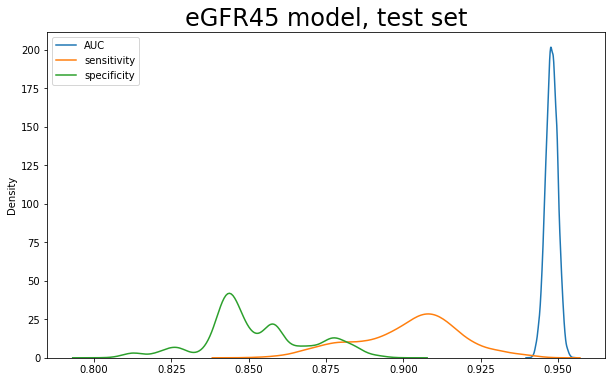

auc mean: 0.95 (0.94-0.95), median:0.95
se  mean: 0.90 (0.87-0.93), median:0.90
sp  mean: 0.85 (0.82-0.88), median:0.85
th  mean: 0.46 (0.36-0.57), median:0.44


In [17]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box, label='AUC') 
sns.kdeplot(se_box, label='sensitivity')
sns.kdeplot(sp_box, label='specificity')
plt.title("eGFR45 model, test set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box), lower_auc, upper_auc, np.median(auc_box)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box), lower_se, upper_se, np.median(se_box)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box), lower_sp, upper_sp, np.median(sp_box)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box), lower_th, upper_th, np.median(th_box)))

### external bootstrap

In [111]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv")
ev_wt = ev_wt.query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['leucocyte'] = np.nan
ev['eGFR_ab45'] = np.where(ev['eGFR_ckd']<45,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab45']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features_ev[std_cols]
X_test_features_ev[std_cols]=scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=423, ratio=0.67
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.052137,-0.528460,0.579458,0.094305,0.117039,0.143218
std,0.497665,0.784417,1.005529,1.027015,0.539820,0.409067,1.029530
min,0.000000,-1.719827,-1.437303,0.000000,0.000000,0.000000,-1.872494
25%,0.000000,-0.456682,-1.437303,0.000000,0.000000,0.000000,-0.652658
50%,0.000000,0.174890,-0.830620,0.000000,0.000000,0.000000,0.181966
75%,1.000000,0.806462,0.382745,1.000000,0.000000,0.000000,0.952388
max,1.000000,1.438034,3.416158,5.000000,5.000000,5.000000,2.043819


In [112]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
X_test_bs_ev = ev.copy()
X_test_bs_ev['prob'] = y_prob_ev
X_test_bs_ev

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,...,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,eGFR_ab45,wt,prob
210862,A901021301,0,76.36104,1,78,5.5,0,1.020,0,0,...,0,0,0,NaN,knhanes,1.0,0.0,0,320.734691,0.800577
210863,A901021302,0,90.97259,0,75,6.0,0,1.025,0,0,...,0,0,0,NaN,knhanes,1.0,1.0,0,456.006780,0.642490
210864,A901022601,0,106.45850,0,43,6.0,0,1.020,0,0,...,0,0,0,NaN,knhanes,0.0,0.0,0,592.556654,0.030987
210865,A901023304,0,85.96295,0,71,6.0,0,1.020,0,4,...,0,0,0,NaN,knhanes,1.0,1.0,0,288.311428,0.582085
210866,A901023502,0,110.41680,0,42,8.5,0,1.020,0,0,...,0,0,0,NaN,knhanes,0.0,0.0,0,592.556654,0.019611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273802,P549819801,0,75.12561,0,74,5.0,0,1.025,0,0,...,0,4,0,NaN,knhanes,0.0,NaN,0,108.891200,0.807340
273803,P549879801,0,71.56396,1,75,5.0,0,1.025,0,0,...,0,2,0,NaN,knhanes,0.0,NaN,0,201.759400,0.822790
273804,P549879802,0,66.76084,0,74,5.0,0,1.015,0,0,...,0,1,0,NaN,knhanes,0.0,NaN,0,163.336800,0.847047
273805,P549980702,0,90.97181,0,34,5.0,0,1.030,0,0,...,0,1,0,NaN,knhanes,0.0,NaN,0,232.329500,0.035059


In [113]:
# load dataset
data = X_test_bs_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_ev = []
th_box_ev = []
se_box_ev = []
sp_box_ev = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
    
    auc_box_ev.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_ev.append(best_thresh)
    se_box_ev.append(se)
    sp_box_ev.append(sp)

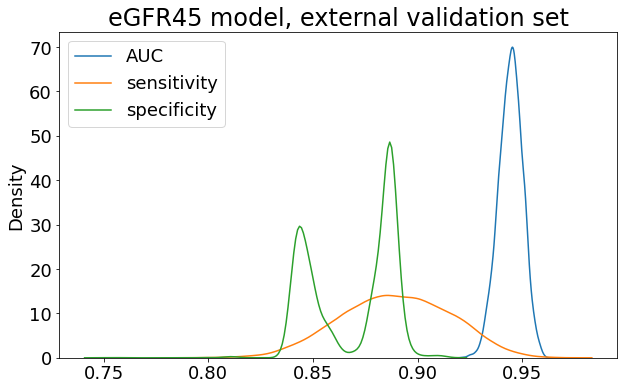

auc mean: 0.94 (0.93-0.96), median:0.94
se  mean: 0.89 (0.84-0.94), median:0.89
sp  mean: 0.87 (0.84-0.89), median:0.88
th  mean: 0.46 (0.39-0.53), median:0.49


In [114]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_ev, label='AUC') 
sns.kdeplot(se_box_ev, label='sensitivity')
sns.kdeplot(sp_box_ev, label='specificity')
plt.title("eGFR45 model, external validation set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_ev, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_ev), lower_auc, upper_auc, np.median(auc_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_ev, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_ev), lower_se, upper_se, np.median(se_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_ev, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_ev), lower_sp, upper_sp, np.median(sp_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_ev, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_ev), lower_th, upper_th, np.median(th_box_ev)))

### ROC

#### internal

eGFR45 model

Classification Report

Best Threshold=0.434, sensitivity = 0.91, specificity = 0.84, J=0.752
              precision    recall  f1-score   support

      normal       1.00      0.84      0.91     64082
    abnormal       0.15      0.91      0.25      1925

    accuracy                           0.84     66007
   macro avg       0.57      0.88      0.58     66007
weighted avg       0.97      0.84      0.89     66007



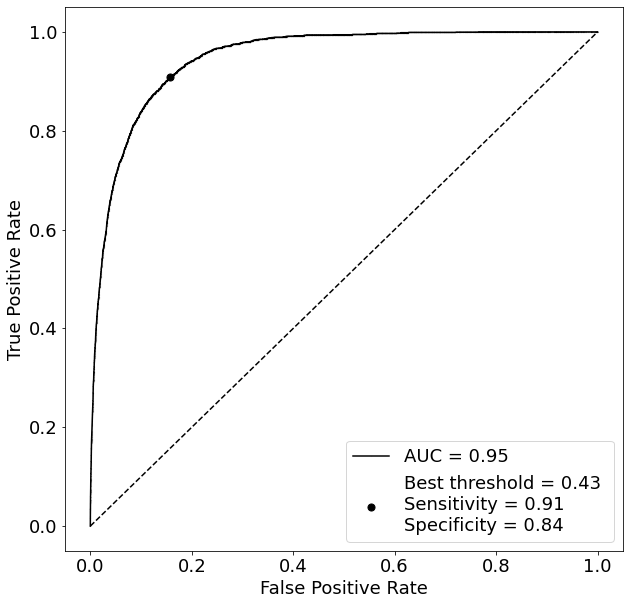

In [22]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_bs['prob']
y_test = X_test_bs['eGFR_ab45']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('eGFR45 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### external

eGFR45 model, knhanes, external validation

Classification Report

Best Threshold=0.511, sensitivity = 0.87, specificity = 0.89, J=0.753
              precision    recall  f1-score   support

      normal       1.00      0.89      0.94 35299350.09501054
    abnormal       0.04      0.87      0.07 170448.78159155548

    accuracy                           0.89 35469798.8766021
   macro avg       0.52      0.88      0.50 35469798.8766021
weighted avg       0.99      0.89      0.94 35469798.8766021



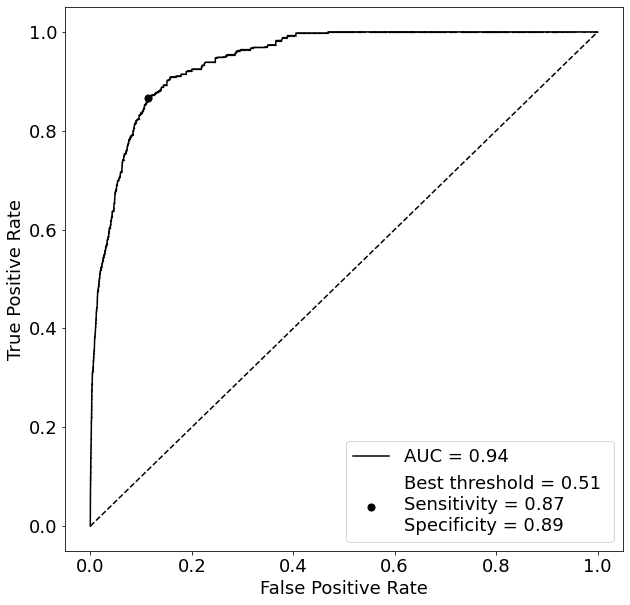

In [115]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]

print('eGFR45 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev >= best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### both internal and external

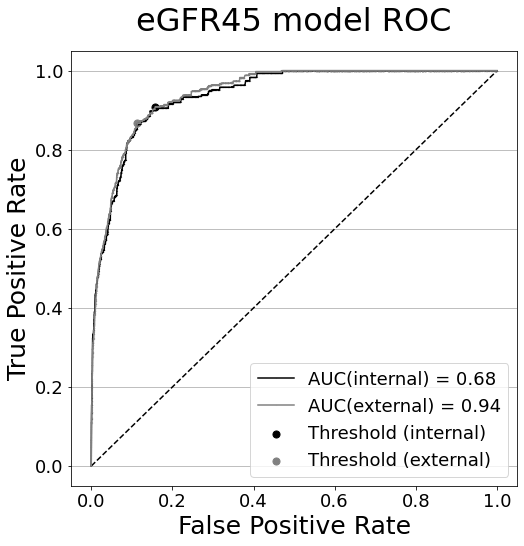

In [116]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-spec, sens, marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-spec_ev, sens_ev, marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR45 model ROC', size=32, pad=20)
# show the plot
#plt.show()

plt.grid(axis='y')
#plt.ylim(1.0)
# save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_roc.png', dpi=300)

# SHAP value

In [25]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 153945/154013 [25:36<00:00]        

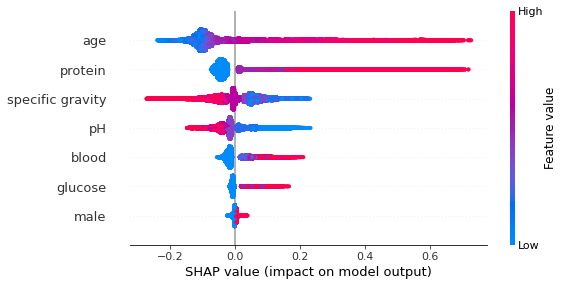

In [26]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [27]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [28]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 65997/66007 [11:01<00:00]        

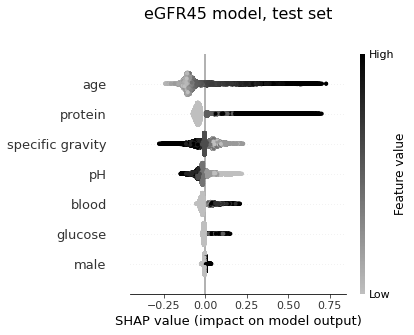

In [29]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR45 model, test set', fontsize=16, pad=35)
plt.tight_layout()

plt.grid('off')
plt.grid(b=None)

#save as png
#plt.savefig('/home/danssa/proj_ua/images/5sub/60model_shap.png', dpi=300)

# sub group analysis, internal : DM, HTN, old age, proteinuria

In [30]:
# subset each group
X_test_g1 = X_test_bs.query('dm==1')
X_test_g2 = X_test_bs.query('htn==1')
X_test_g3 = X_test_bs.query('age>=65')
X_test_g4 = X_test_bs.query('he_upro>1')
X_test_g5 = X_test_bs.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [31]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (len(X_test_g1), sum(X_test_g1['eGFR_ab45'])/len(X_test_g1)*100, sum(X_test_g1['eGFR_ab45'])))
print('group2: %d, %.1f (%d)' % (len(X_test_g2), sum(X_test_g2['eGFR_ab45'])/len(X_test_g2)*100, sum(X_test_g2['eGFR_ab45'])))
print('group3: %d, %.1f (%d)' % (len(X_test_g3), sum(X_test_g3['eGFR_ab45'])/len(X_test_g3)*100, sum(X_test_g3['eGFR_ab45'])))
print('group4: %d, %.1f (%d)' % (len(X_test_g4), sum(X_test_g4['eGFR_ab45'])/len(X_test_g4)*100, sum(X_test_g4['eGFR_ab45'])))
print('group5: %d, %.1f (%d)' % (len(X_test_g5), sum(X_test_g5['eGFR_ab45'])/len(X_test_g5)*100, sum(X_test_g5['eGFR_ab45'])))

total cases, prevalence (cases)
group1: 1673, 2.1 (35)
group2: 2597, 0.9 (23)
group3: 10734, 11.8 (1264)
group4: 5663, 17.3 (977)
group5: 2214, 24.8 (548)


In [32]:
print('train old age & diabetes', 
      sum(X_train.query('age>=65&dm==1')['eGFR_ab45'])/len(X_train.query('age>=65&dm==1')),
      sum(X_train.query('age>=65&dm==0')['eGFR_ab45'])/len(X_train.query('age>=65&dm==0')))

train old age & diabetes 0.06575682382133995 0.12210780839621461


In [33]:
print('test old age & diabetes',
      sum(X_test_g3.query('dm==1')['eGFR_ab45'])/len(X_test_g3.query('dm==1')),
      sum(X_test_g3.query('dm==0')['eGFR_ab45'])/len(X_test_g3.query('dm==0')))

test old age & diabetes 0.045454545454545456 0.12036679536679537


## sub1 : DM

In [34]:
# test set
data = X_test_g1

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1 = []
th_box_s1 = []
se_box_s1 = []
sp_box_s1 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box_s1.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s1.append(best_thresh)
    se_box_s1.append(se)
    sp_box_s1.append(sp)

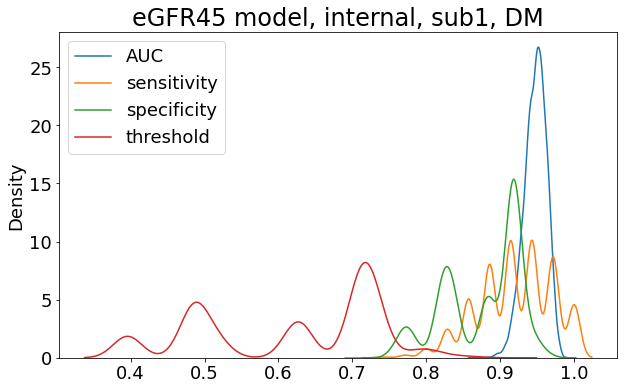

auc mean: 0.95 (0.92-0.97), median:0.95
se  mean: 0.92 (0.83-1.00), median:0.91
sp  mean: 0.88 (0.77-0.95), median:0.89
th  mean: 0.62 (0.40-0.79), median:0.63


In [35]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1, label='AUC') 
sns.kdeplot(se_box_s1, label='sensitivity')
sns.kdeplot(sp_box_s1, label='specificity')
sns.kdeplot(th_box_s1, label='threshold')
plt.title("eGFR45 model, internal, sub1, DM", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s1, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s1), lower_auc, upper_auc, np.median(auc_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s1, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s1), lower_se, upper_se, np.median(se_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s1, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s1), lower_sp, upper_sp, np.median(sp_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s1, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s1), lower_th, upper_th, np.median(th_box_s1)))

In [36]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1['prob']
y_test = X_test_g1['eGFR_ab45']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group1')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR45 model, group1
AUC         : 0.95
sensitivity : 0.86
specificity : 0.92
Threshold   : 0.71

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.92      0.95      1638
    abnormal       0.18      0.86      0.29        35

    accuracy                           0.91      1673
   macro avg       0.59      0.89      0.62      1673
weighted avg       0.98      0.91      0.94      1673



## sub2 : HTN

In [37]:
# test set
data = X_test_g2

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2 = []
th_box_s2 = []
se_box_s2 = []
sp_box_s2 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box_s2.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s2.append(best_thresh)
    se_box_s2.append(se)
    sp_box_s2.append(sp)

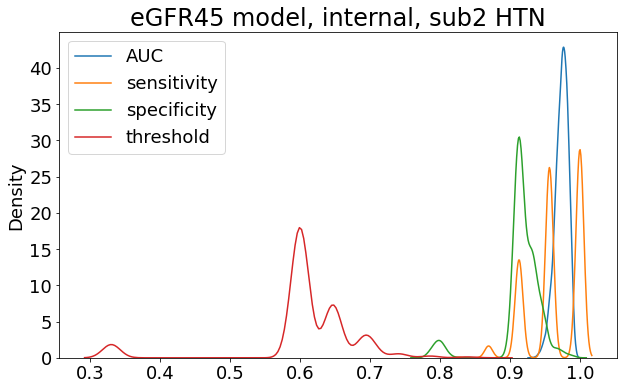

auc mean: 0.97 (0.95-0.99), median:0.97
se  mean: 0.96 (0.91-1.00), median:0.96
sp  mean: 0.92 (0.80-0.96), median:0.92
th  mean: 0.61 (0.33-0.74), median:0.60


In [38]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2, label='AUC') 
sns.kdeplot(se_box_s2, label='sensitivity')
sns.kdeplot(sp_box_s2, label='specificity')
sns.kdeplot(th_box_s2, label="threshold")
plt.title("eGFR45 model, internal, sub2 HTN", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s2, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s2), lower_auc, upper_auc, np.median(auc_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s2, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s2), lower_se, upper_se, np.median(se_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s2, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s2), lower_sp, upper_sp, np.median(sp_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s2, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s2), lower_th, upper_th, np.median(th_box_s2)))

In [39]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2['prob']
y_test = X_test_g2['eGFR_ab45']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group2')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR45 model, group2
AUC         : 0.97
sensitivity : 0.96
specificity : 0.91
Threshold   : 0.60

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.91      0.95      2574
    abnormal       0.09      0.96      0.16        23

    accuracy                           0.91      2597
   macro avg       0.54      0.93      0.56      2597
weighted avg       0.99      0.91      0.95      2597



## sub3 : old age, age>=65

In [40]:
# test set
data = X_test_g3

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3 = []
th_box_s3 = []
se_box_s3 = []
sp_box_s3 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box_s3.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s3.append(best_thresh)
    se_box_s3.append(se)
    sp_box_s3.append(sp)

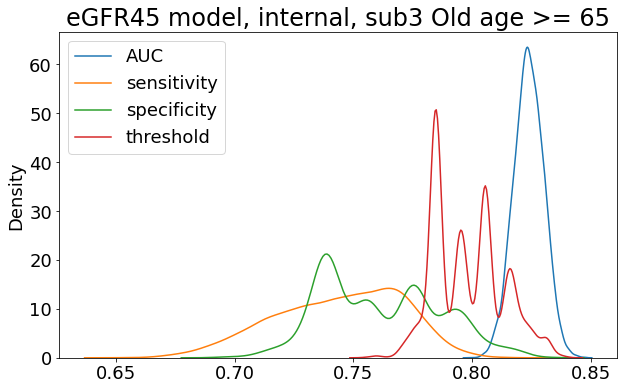

auc mean: 0.82 (0.81-0.84), median:0.82
se  mean: 0.74 (0.69-0.79), median:0.75
sp  mean: 0.76 (0.72-0.81), median:0.76
th  mean: 0.80 (0.77-0.83), median:0.80


In [41]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3, label='AUC') 
sns.kdeplot(se_box_s3, label='sensitivity')
sns.kdeplot(sp_box_s3, label='specificity')
sns.kdeplot(th_box_s3, label='threshold')
plt.title("eGFR45 model, internal, sub3 Old age >= 65", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s3, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s3), lower_auc, upper_auc, np.median(auc_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s3, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s3), lower_se, upper_se, np.median(se_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s3, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s3), lower_sp, upper_sp, np.median(sp_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s3, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s3), lower_th, upper_th, np.median(th_box_s3)))

In [42]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3['prob']
y_test = X_test_g3['eGFR_ab45']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group3')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR45 model, group3
AUC         : 0.82
sensitivity : 0.76
specificity : 0.74
Threshold   : 0.78

Classification Report

              precision    recall  f1-score   support

      normal       0.96      0.74      0.83      9470
    abnormal       0.28      0.76      0.41      1264

    accuracy                           0.74     10734
   macro avg       0.62      0.75      0.62     10734
weighted avg       0.88      0.74      0.78     10734



## sub4 : proteinuria

In [43]:
# test set
data = X_test_g4

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

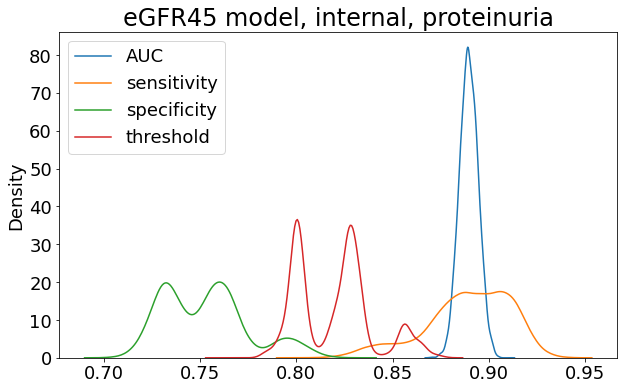

auc mean: 0.89 (0.88-0.90), median:0.89
se  mean: 0.89 (0.84-0.92), median:0.89
sp  mean: 0.75 (0.72-0.80), median:0.75
th  mean: 0.82 (0.79-0.86), median:0.82


In [44]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR45 model, internal, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [45]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4['prob']
y_test = X_test_g4['eGFR_ab45']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group4')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR45 model, group4
AUC         : 0.89
sensitivity : 0.88
specificity : 0.76
Threshold   : 0.83

Classification Report

              precision    recall  f1-score   support

      normal       0.97      0.76      0.85      4686
    abnormal       0.43      0.88      0.58       977

    accuracy                           0.78      5663
   macro avg       0.70      0.82      0.72      5663
weighted avg       0.88      0.78      0.80      5663



## sub5 : age>=65 and (dm or htn or proteinuria)

In [46]:
# test set
data = X_test_g5

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
    auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

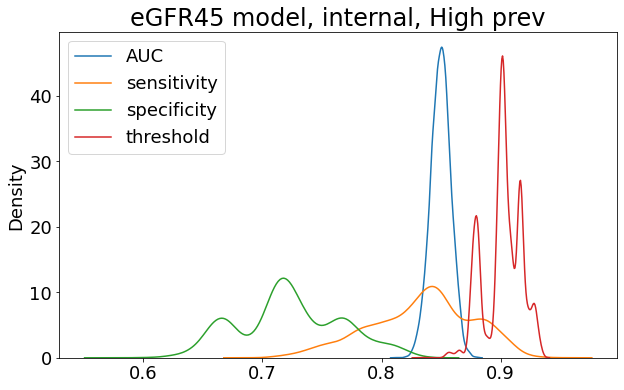

auc mean: 0.85 (0.83-0.87), median:0.85
se  mean: 0.83 (0.74-0.91), median:0.84
sp  mean: 0.72 (0.65-0.81), median:0.72
th  mean: 0.90 (0.88-0.93), median:0.90


In [47]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR45 model, internal, High prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [48]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5['prob']
y_test = X_test_g5['eGFR_ab45']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group5')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR45 model, group5
AUC         : 0.85
sensitivity : 0.84
specificity : 0.72
Threshold   : 0.90

Classification Report

              precision    recall  f1-score   support

      normal       0.93      0.72      0.81      1666
    abnormal       0.49      0.84      0.62       548

    accuracy                           0.75      2214
   macro avg       0.71      0.78      0.71      2214
weighted avg       0.82      0.75      0.76      2214



## accuracy in eGFR<60, eGFR<45 and eGFR<30

### internal

### all

In [49]:
X_test_bs['pred'] = np.where(X_test_bs['prob']>=0.48, 1, 0)
X_test_bs['pred'].value_counts()

# 60
X_test_bs60 = X_test_bs.query('eGFR_ckd<60')
X_test_bs60['acc'] = X_test_bs60['eGFR_ab'] == X_test_bs60['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_bs60), sum(X_test_bs60['acc']), sum(X_test_bs60['acc'])/len(X_test_bs60)*100))

#45
X_test_bs45 = X_test_bs.query('eGFR_ckd<45')
X_test_bs45['eGFR_ab45'] = np.where(X_test_bs45['eGFR_ckd']<45,1,0)
X_test_bs45['acc'] = X_test_bs45['eGFR_ab45'] == X_test_bs45['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_bs45), sum(X_test_bs45['acc']), sum(X_test_bs45['acc'])/len(X_test_bs45)*100))

#30
X_test_bs30 = X_test_bs.query('eGFR_ckd<30')
X_test_bs30['eGFR_ab30'] = np.where(X_test_bs30['eGFR_ckd']<30,1,0)
X_test_bs30['acc'] = X_test_bs30['eGFR_ab30'] == X_test_bs30['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_bs30), sum(X_test_bs30['acc']), sum(X_test_bs30['acc'])/len(X_test_bs30)*100))

60all: 4432 right: 3367 ratio: 76.0
45all: 1925 right: 1717 ratio: 89.2
30all: 929 right: 873 ratio: 94.0


In [50]:
# confidence intervals
def cical(box, alpha=0.95):
    p = ((1.0-alpha)/2.0)*100
    lower = max(0.0, np.percentile(box, p))
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = min(1.0, np.percentile(box, p))
   # mean = mean(box)
    median = np.median(box)
    
    return print('mean(ci): %.2f (%.2f-%.2f), median:%.2f' % (mean(box), lower, upper, np.median(box)))

In [51]:
# test set
data = X_test_bs60

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_all_60, acc = [], []
se_all_45, acc45 = [], []
se_all_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_all_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_all_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_all_30.append(se30)
        
        pbar.update()

10000it [01:03, 157.85it/s]                         


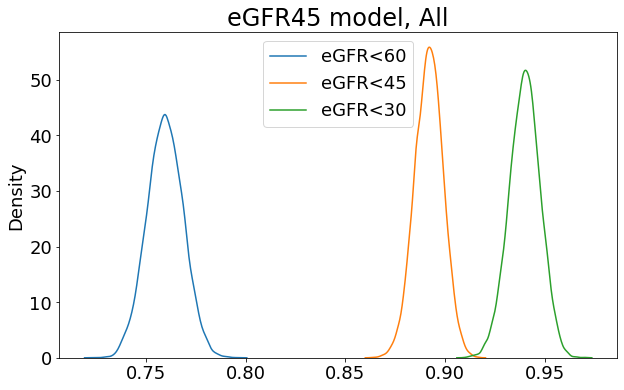

mean(ci): 0.76 (0.74-0.78), median:0.76
mean(ci): 0.89 (0.88-0.91), median:0.89
mean(ci): 0.94 (0.92-0.95), median:0.94


In [52]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_all_60, label='eGFR<60') 
sns.kdeplot(se_all_45, label='eGFR<45') 
sns.kdeplot(se_all_30, label='eGFR<30') 
plt.title("eGFR45 model, All", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_all_60)
cical(se_all_45)
cical(se_all_30)

### group1, diabetes

In [53]:
X_test_g1['pred'] = np.where(X_test_g1['prob']>=0.67, 1, 0)
X_test_g1['pred'].value_counts()

# 60
X_test_g160 = X_test_g1.query('eGFR_ckd<60')
X_test_g160['acc'] = X_test_g160['eGFR_ab'] == X_test_g160['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g160), sum(X_test_g160['acc']), sum(X_test_g160['acc'])/len(X_test_g160)*100))

#45
X_test_g145 = X_test_g1.query('eGFR_ckd<45')
X_test_g145['eGFR_ab45'] = np.where(X_test_g145['eGFR_ckd']<45,1,0)
X_test_g145['acc'] = X_test_g145['eGFR_ab45'] == X_test_g145['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g145), sum(X_test_g145['acc']), sum(X_test_g145['acc'])/len(X_test_g145)*100))

#30
X_test_g130 = X_test_g1.query('eGFR_ckd<30')
X_test_g130['eGFR_ab30'] = np.where(X_test_g130['eGFR_ckd']<30,1,0)
X_test_g130['acc'] = X_test_g130['eGFR_ab30'] == X_test_g130['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g130), sum(X_test_g130['acc']), sum(X_test_g130['acc'])/len(X_test_g130)*100))

60all: 86 right: 55 ratio: 64.0
45all: 35 right: 30 ratio: 85.7
30all: 24 right: 21 ratio: 87.5


In [54]:
# test set
data = X_test_g160

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g1_60, acc = [], []
se_g1_45, acc45 = [], []
se_g1_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g1_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g1_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g1_30.append(se30)
        
        pbar.update()

10000it [00:53, 186.04it/s]                     


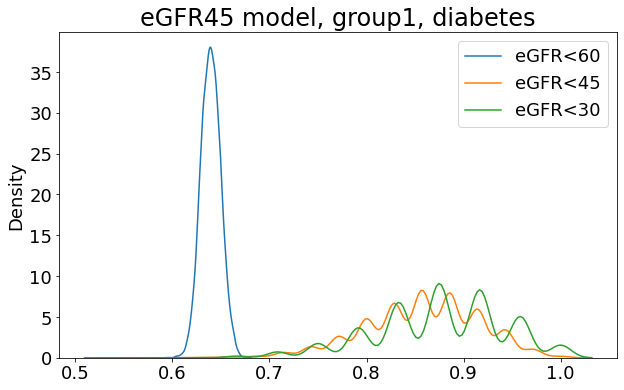

mean(ci): 0.64 (0.62-0.66), median:0.64
mean(ci): 0.86 (0.74-0.97), median:0.86
mean(ci): 0.87 (0.71-1.00), median:0.88


In [55]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g1_60, label='eGFR<60') 
sns.kdeplot(se_g1_45, label='eGFR<45') 
sns.kdeplot(se_g1_30, label='eGFR<30') 
plt.title("eGFR45 model, group1, diabetes", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g1_60)
cical(se_g1_45)
cical(se_g1_30)

### group2, hypertension

In [56]:
X_test_g2['pred'] = np.where(X_test_g2['prob']>=0.65, 1, 0)
X_test_g2['pred'].value_counts()

# 60
X_test_g260 = X_test_g2.query('eGFR_ckd<60')
X_test_g260['acc'] = X_test_g260['eGFR_ab'] == X_test_g260['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g260), sum(X_test_g260['acc']), sum(X_test_g260['acc'])/len(X_test_g260)*100))

#45
X_test_g245 = X_test_g2.query('eGFR_ckd<45')
X_test_g245['eGFR_ab45'] = np.where(X_test_g245['eGFR_ckd']<45,1,0)
X_test_g245['acc'] = X_test_g245['eGFR_ab45'] == X_test_g245['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g245), sum(X_test_g245['acc']), sum(X_test_g245['acc'])/len(X_test_g245)*100))

#30
X_test_g230 = X_test_g2.query('eGFR_ckd<30')
X_test_g230['eGFR_ab30'] = np.where(X_test_g230['eGFR_ckd']<30,1,0)
X_test_g230['acc'] = X_test_g230['eGFR_ab30'] == X_test_g230['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g230), sum(X_test_g230['acc']), sum(X_test_g230['acc'])/len(X_test_g230)*100))

60all: 60 right: 33 ratio: 55.0
45all: 23 right: 20 ratio: 87.0
30all: 10 right: 9 ratio: 90.0


In [57]:
# test set
data = X_test_g260

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g2_60, acc = [], []
se_g2_45, acc45 = [], []
se_g2_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g2_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g2_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g2_30.append(se30)
        
        pbar.update()

10000it [00:53, 186.95it/s]                     


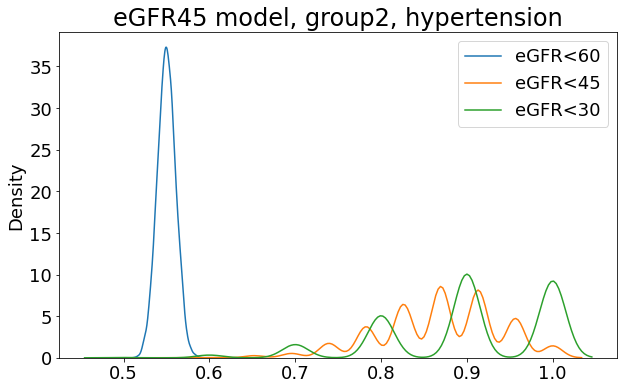

mean(ci): 0.55 (0.53-0.57), median:0.55
mean(ci): 0.87 (0.74-1.00), median:0.87
mean(ci): 0.90 (0.70-1.00), median:0.90


In [58]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g2_60, label='eGFR<60') 
sns.kdeplot(se_g2_45, label='eGFR<45') 
sns.kdeplot(se_g2_30, label='eGFR<30') 
plt.title("eGFR45 model, group2, hypertension", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g2_60)
cical(se_g2_45)
cical(se_g2_30)

### group3, old age >= 65

In [59]:
X_test_g3['pred'] = np.where(X_test_g3['prob']>=0.83, 1, 0)
X_test_g3['pred'].value_counts()

# 60
X_test_g360 = X_test_g3.query('eGFR_ckd<60')
X_test_g360['acc'] = X_test_g360['eGFR_ab'] == X_test_g360['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g360), sum(X_test_g360['acc']), sum(X_test_g360['acc'])/len(X_test_g360)*100))

#45
X_test_g345 = X_test_g3.query('eGFR_ckd<45')
X_test_g345['eGFR_ab45'] = np.where(X_test_g345['eGFR_ckd']<45,1,0)
X_test_g345['acc'] = X_test_g345['eGFR_ab45'] == X_test_g345['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g345), sum(X_test_g345['acc']), sum(X_test_g345['acc'])/len(X_test_g345)*100))

#30
X_test_g330 = X_test_g3.query('eGFR_ckd<30')
X_test_g330['eGFR_ab30'] = np.where(X_test_g330['eGFR_ckd']<30,1,0)
X_test_g330['acc'] = X_test_g330['eGFR_ab30'] == X_test_g330['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g330), sum(X_test_g330['acc']), sum(X_test_g330['acc'])/len(X_test_g330)*100))

60all: 2961 right: 1388 ratio: 46.9
45all: 1264 right: 857 ratio: 67.8
30all: 537 right: 447 ratio: 83.2


In [60]:
# test set
data = X_test_g360

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g3_60, acc = [], []
se_g3_45, acc45 = [], []
se_g3_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g3_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g3_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g3_30.append(se30)
        
        pbar.update()

10000it [01:00, 166.52it/s]                         


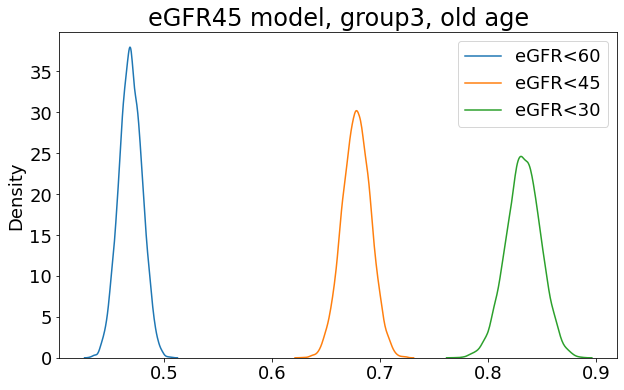

mean(ci): 0.47 (0.45-0.49), median:0.47
mean(ci): 0.68 (0.65-0.70), median:0.68
mean(ci): 0.83 (0.80-0.86), median:0.83


In [61]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g3_60, label='eGFR<60') 
sns.kdeplot(se_g3_45, label='eGFR<45') 
sns.kdeplot(se_g3_30, label='eGFR<30') 
plt.title("eGFR45 model, group3, old age", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g3_60)
cical(se_g3_45)
cical(se_g3_30)

### group4, proteinuria

In [62]:
X_test_g4['pred'] = np.where(X_test_g4['prob']>=0.83, 1, 0)
X_test_g4['pred'].value_counts()

# 60
X_test_g460 = X_test_g4.query('eGFR_ckd<60')
X_test_g460['acc'] = X_test_g460['eGFR_ab'] == X_test_g460['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g460), sum(X_test_g460['acc']), sum(X_test_g460['acc'])/len(X_test_g460)*100))

#45
X_test_g445 = X_test_g4.query('eGFR_ckd<45')
X_test_g445['eGFR_ab45'] = np.where(X_test_g445['eGFR_ckd']<45,1,0)
X_test_g445['acc'] = X_test_g445['eGFR_ab45'] == X_test_g445['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g445), sum(X_test_g445['acc']), sum(X_test_g445['acc'])/len(X_test_g445)*100))

#30
X_test_g430 = X_test_g4.query('eGFR_ckd<30')
X_test_g430['eGFR_ab30'] = np.where(X_test_g430['eGFR_ckd']<30,1,0)
X_test_g430['acc'] = X_test_g430['eGFR_ab30'] == X_test_g430['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g430), sum(X_test_g430['acc']), sum(X_test_g430['acc'])/len(X_test_g430)*100))

60all: 1452 right: 1165 ratio: 80.2
45all: 977 right: 851 ratio: 87.1
30all: 634 right: 561 ratio: 88.5


In [63]:
# test set
data = X_test_g460

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g4_60, acc = [], []
se_g4_45, acc45 = [], []
se_g4_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g4_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g4_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g4_30.append(se30)
        
        pbar.update()

10000it [00:58, 170.38it/s]                         


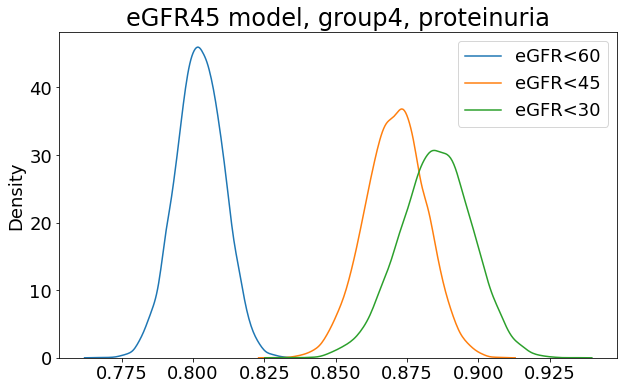

mean(ci): 0.80 (0.79-0.82), median:0.80
mean(ci): 0.87 (0.85-0.89), median:0.87
mean(ci): 0.88 (0.86-0.91), median:0.88


In [64]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g4_60, label='eGFR<60') 
sns.kdeplot(se_g4_45, label='eGFR<45') 
sns.kdeplot(se_g4_30, label='eGFR<30') 
plt.title("eGFR45 model, group4, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g4_60)
cical(se_g4_45)
cical(se_g4_30)

### group5, high prevalence

In [65]:
X_test_g5['pred'] = np.where(X_test_g5['prob']>=0.90, 1, 0)
X_test_g5['pred'].value_counts()

# 60
X_test_g560 = X_test_g5.query('eGFR_ckd<60')
X_test_g560['acc'] = X_test_g560['eGFR_ab'] == X_test_g560['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g560), sum(X_test_g560['acc']), sum(X_test_g560['acc'])/len(X_test_g560)*100))

#45
X_test_g545 = X_test_g5.query('eGFR_ckd<45')
X_test_g545['eGFR_ab45'] = np.where(X_test_g545['eGFR_ckd']<45,1,0)
X_test_g545['acc'] = X_test_g545['eGFR_ab45'] == X_test_g545['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g545), sum(X_test_g545['acc']), sum(X_test_g545['acc'])/len(X_test_g545)*100))

#30
X_test_g530 = X_test_g5.query('eGFR_ckd<30')
X_test_g530['eGFR_ab30'] = np.where(X_test_g530['eGFR_ckd']<30,1,0)
X_test_g530['acc'] = X_test_g530['eGFR_ab30'] == X_test_g530['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g530), sum(X_test_g530['acc']), sum(X_test_g530['acc'])/len(X_test_g530)*100))

60all: 868 right: 633 ratio: 72.9
45all: 548 right: 459 ratio: 83.8
30all: 333 right: 298 ratio: 89.5


In [66]:
# test set
data = X_test_g560

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g5_60, acc = [], []
se_g5_45, acc45 = [], []
se_g5_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g5_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g5_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g5_30.append(se30)
        
        pbar.update()

10000it [00:56, 176.37it/s]                       


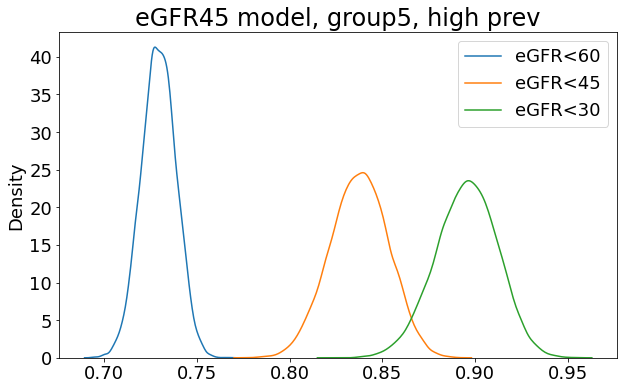

mean(ci): 0.73 (0.71-0.75), median:0.73
mean(ci): 0.84 (0.81-0.87), median:0.84
mean(ci): 0.90 (0.86-0.92), median:0.89


In [67]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g5_60, label='eGFR<60') 
sns.kdeplot(se_g5_45, label='eGFR<45') 
sns.kdeplot(se_g5_30, label='eGFR<30') 
plt.title("eGFR45 model, group5, high prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g5_60)
cical(se_g5_45)
cical(se_g5_30)

In [68]:
df_se_trend = pd.DataFrame({
    'eGFR' : ['eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30'],
    
    'se'   : [0.87, 0.93, 0.95, 
              0.77, 0.83, 0.83, 
              0.86, 1.00, 1.00, 
              0.65, 0.81, 0.90, 
              0.81, 0.85, 0.86, 
              0.78, 0.86, 0.91],
    
    'lower' : [0.86, 0.92, 0.94,
              0.76, 0.70, 0.67,
              0.85, 1.00, 1.00,
              0.64, 0.78, 0.87,
              0.80, 0.83, 0.83,
              0.77, 0.83, 0.88],
    
    'upper' : [0.88, 0.94, 0.97,
              0.78, 0.97, 1.00,
              0.87, 1.00, 1.00,
              0.66, 0.83, 0.92,
              0.82, 0.87, 0.88,
              0.79, 0.89, 0.94],
    
    'group'  : ['All', 'All', 'All',
               'Diabetes', 'Diabetes', 'Diabetes',
               'Hypertension', 'Hypertension', 'Hypertension',
               'Old age', 'Old age', 'Old age',
               'Proteinuria','Proteinuria','Proteinuria',
               'High prev','High prev','High prev']
})
df_se_trend['lower'] = df_se_trend['se'] - df_se_trend['lower']
df_se_trend['upper'] = df_se_trend['upper'] - df_se_trend['se']
df_se_trend

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
3,eGFR<60,0.77,0.01,0.01,Diabetes
4,eGFR<45,0.83,0.13,0.14,Diabetes
5,eGFR<30,0.83,0.16,0.17,Diabetes
6,eGFR<60,0.86,0.01,0.01,Hypertension
7,eGFR<45,1.00,0.00,0.00,Hypertension
8,eGFR<30,1.00,0.00,0.00,Hypertension
9,eGFR<60,0.65,0.01,0.01,Old age


In [69]:
df_se_trend_sub = df_se_trend.query('group=="All"|group=="Old age"|group=="High prev"')
df_se_trend_sub

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
9,eGFR<60,0.65,0.01,0.01,Old age
10,eGFR<45,0.81,0.03,0.02,Old age
11,eGFR<30,0.90,0.03,0.02,Old age
15,eGFR<60,0.78,0.01,0.01,High prev
16,eGFR<45,0.86,0.03,0.03,High prev
17,eGFR<30,0.91,0.03,0.03,High prev


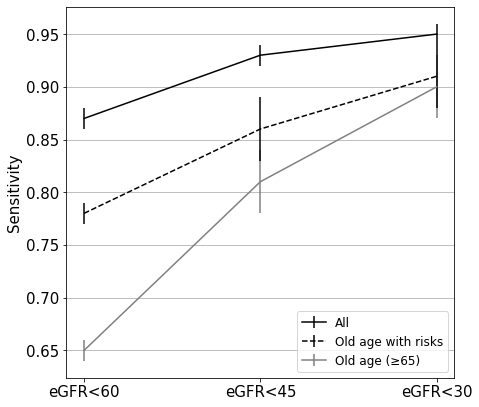

In [70]:
# trends of sensitivities plot
plt.rcParams["figure.figsize"] = (7,6)
fig,ax = plt.subplots()
#sns.set(style= "whitegrid")

df = df_se_trend_sub
lvls = df.group.unique()
#for i in lvls:
#    ax.errorbar(x = df[df['group']==i]["eGFR"],
#                y=df[df['group']==i]["se"], 
#                yerr=[df[df['group']==i]["lower"], df[df['group']==i]["lower"]],
#               label=i)
    
ax.errorbar(x = df[df['group']=='All']["eGFR"],
            y=df[df['group']=='All']["se"], 
            yerr=[df[df['group']=='All']["lower"], df[df['group']=='All']["lower"]],
            label='All', color='k', linestyle='-')

ax.errorbar(x = df[df['group']=='Old age']["eGFR"],
            y=df[df['group']=='Old age']["se"], 
            yerr=[df[df['group']=='Old age']["lower"], df[df['group']=='Old age']["lower"]],
            label='Old age (≥65)', color='grey')

ax.errorbar(x = df[df['group']=='High prev']["eGFR"],
            y=df[df['group']=='High prev']["se"], 
            yerr=[df[df['group']=='High prev']["lower"], df[df['group']=='High prev']["lower"]],
            label='Old age with risks', color='k', linestyle='--')

#ax.axhline(y=0.5 , color='k', linestyle='--')
#ax.legend(loc=4, prop={'size':12})
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4, fontsize=12)

#plt.show()
plt.grid(axis='y')
plt.tight_layout()

#plt.savefig('/home/danssa/proj_ua/images/5sub/old_sen_internal.png', dpi=300)

# external subgroup analysis

## sub group analysis, internal : DM, HTN, old age, proteinuria

In [117]:
# subset each group
X_test_g1_ev = X_test_bs_ev.query('dm==1')
X_test_g2_ev = X_test_bs_ev.query('htn==1')
X_test_g3_ev = X_test_bs_ev.query('age>=65')
X_test_g4_ev = X_test_bs_ev.query('he_upro>1')
X_test_g5_ev = X_test_bs_ev.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [118]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (sum(X_test_g1_ev['wt']), sum(X_test_g1_ev.query('eGFR_ab45==1')['wt'])/sum(X_test_g1_ev['wt'])*100, sum(X_test_g1_ev.query('eGFR_ab45==1')['wt'])))
print('group2: %d, %.1f (%d)' % (sum(X_test_g2_ev['wt']), sum(X_test_g2_ev.query('eGFR_ab45==1')['wt'])/sum(X_test_g2_ev['wt'])*100, sum(X_test_g2_ev.query('eGFR_ab45==1')['wt'])))
print('group3: %d, %.1f (%d)' % (sum(X_test_g3_ev['wt']), sum(X_test_g3_ev.query('eGFR_ab45==1')['wt'])/sum(X_test_g3_ev['wt'])*100, sum(X_test_g3_ev.query('eGFR_ab45==1')['wt'])))
print('group4: %d, %.1f (%d)' % (sum(X_test_g4_ev['wt']), sum(X_test_g4_ev.query('eGFR_ab45==1')['wt'])/sum(X_test_g4_ev['wt'])*100, sum(X_test_g4_ev.query('eGFR_ab45==1')['wt'])))
print('group5: %d, %.1f (%d)' % (sum(X_test_g5_ev['wt']), sum(X_test_g5_ev.query('eGFR_ab45==1')['wt'])/sum(X_test_g5_ev['wt'])*100, sum(X_test_g5_ev.query('eGFR_ab45==1')['wt'])))

total cases, prevalence (cases)
group1: 3001786, 2.4 (73384)
group2: 8499212, 1.5 (128923)
group3: 4499556, 2.5 (112747)
group4: 564442, 9.7 (54486)
group5: 2877960, 3.3 (94060)


## sub1 : DM

In [119]:
# test set
data = X_test_g1_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1_ev = []
th_box_s1_ev = []
se_box_s1_ev = []
sp_box_s1_ev = []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
        auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
    
        auc_box_s1_ev.append(auc)
    
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
        th_box_s1_ev.append(best_thresh)
        se_box_s1_ev.append(se)
        sp_box_s1_ev.append(sp)
    
        pbar.update()

10000it [01:00, 164.17it/s]                         


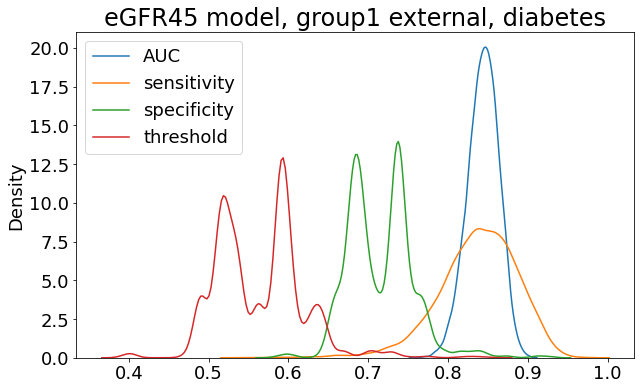

mean(ci): 0.84 (0.80-0.88), median:0.84
mean(ci): 0.84 (0.73-0.92), median:0.84
mean(ci): 0.72 (0.65-0.81), median:0.71
mean(ci): 0.56 (0.49-0.70), median:0.56


In [120]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1_ev, label='AUC') 
sns.kdeplot(se_box_s1_ev, label='sensitivity')
sns.kdeplot(sp_box_s1_ev, label='specificity')
sns.kdeplot(th_box_s1_ev, label='threshold')
plt.title("eGFR45 model, group1 external, diabetes", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s1_ev)
cical(se_box_s1_ev)
cical(sp_box_s1_ev)
cical(th_box_s1_ev)

In [121]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1_ev['prob']
y_test = X_test_g1_ev['eGFR_ab45']
weight = X_test_g1_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group1 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'ab45normal'], sample_weight=weight))

eGFR45 model, group1 external
AUC         : 0.84
sensitivity : 0.81
specificity : 0.73
Threshold   : 0.59

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.73      0.84 2928401.889902913
  ab45normal       0.07      0.81      0.13 73384.26281062057

    accuracy                           0.74 3001786.1527135335
   macro avg       0.53      0.77      0.49 3001786.1527135335
weighted avg       0.97      0.74      0.83 3001786.1527135335



In [122]:
# test set
data = X_test_g2_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2_ev = []
th_box_s2_ev = []
se_box_s2_ev = []
sp_box_s2_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
        auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
    
        auc_box_s2_ev.append(auc)
    
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
        th_box_s2_ev.append(best_thresh)
        se_box_s2_ev.append(se)
        sp_box_s2_ev.append(sp)
    
        pbar.update()

100%|██████████| 10000/10000 [02:14<00:00, 74.18it/s]


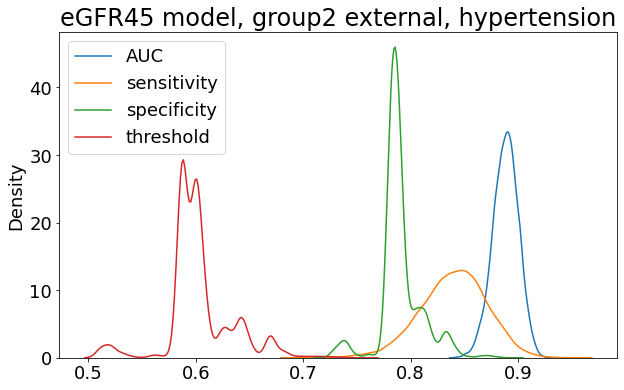

mean(ci): 0.89 (0.86-0.91), median:0.89
mean(ci): 0.84 (0.78-0.90), median:0.84
mean(ci): 0.79 (0.74-0.84), median:0.79
mean(ci): 0.60 (0.52-0.67), median:0.60


In [123]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2_ev, label='AUC') 
sns.kdeplot(se_box_s2_ev, label='sensitivity')
sns.kdeplot(sp_box_s2_ev, label='specificity')
sns.kdeplot(th_box_s2_ev, label='threshold')
plt.title("eGFR45 model, group2 external, hypertension", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s2_ev)
cical(se_box_s2_ev)
cical(sp_box_s2_ev)
cical(th_box_s2_ev)

In [124]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2_ev['prob']
y_test = X_test_g2_ev['eGFR_ab45']
weight = X_test_g2_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group2 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR45 model, group2 external
AUC         : 0.89
sensitivity : 0.84
specificity : 0.78
Threshold   : 0.59

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.78      0.88 8370288.617771274
    abnormal       0.06      0.84      0.11 128923.55891676265

    accuracy                           0.78 8499212.176688038
   macro avg       0.53      0.81      0.49 8499212.176688038
weighted avg       0.98      0.78      0.86 8499212.176688038



In [125]:
# test set
data = X_test_g3_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3_ev = []
th_box_s3_ev = []
se_box_s3_ev = []
sp_box_s3_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
        auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s3_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s3_ev.append(best_thresh)
        se_box_s3_ev.append(se)
        sp_box_s3_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:42<00:00, 97.70it/s]


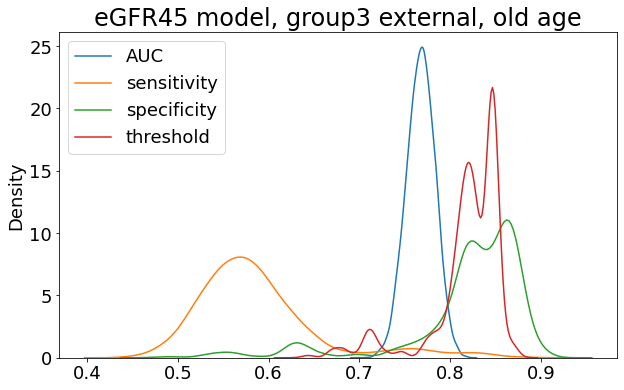

mean(ci): 0.77 (0.74-0.80), median:0.77
mean(ci): 0.59 (0.49-0.80), median:0.57
mean(ci): 0.82 (0.59-0.88), median:0.84
mean(ci): 0.82 (0.70-0.86), median:0.83


In [126]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3_ev, label='AUC') 
sns.kdeplot(se_box_s3_ev, label='sensitivity')
sns.kdeplot(sp_box_s3_ev, label='specificity')
sns.kdeplot(th_box_s3_ev, label='threshold')
plt.title("eGFR45 model, group3 external, old age", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s3_ev)
cical(se_box_s3_ev)
cical(sp_box_s3_ev)
cical(th_box_s3_ev)

In [127]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3_ev['prob']
y_test = X_test_g3_ev['eGFR_ab45']
weight = X_test_g3_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group3 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR45 model, group3 external
AUC         : 0.77
sensitivity : 0.58
specificity : 0.82
Threshold   : 0.82

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.82      0.90 4386808.697694535
    abnormal       0.08      0.58      0.14 112747.88772416746

    accuracy                           0.82 4499556.585418703
   macro avg       0.53      0.70      0.52 4499556.585418703
weighted avg       0.96      0.82      0.88 4499556.585418703



In [128]:
# test set
data = X_test_g4_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4_ev = []
th_box_s4_ev = []
se_box_s4_ev = []
sp_box_s4_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
        auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s4_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s4_ev.append(best_thresh)
        se_box_s4_ev.append(se)
        sp_box_s4_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [00:27<00:00, 358.18it/s]


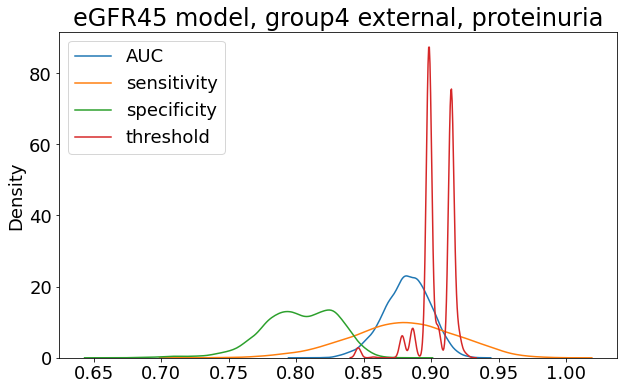

mean(ci): 0.88 (0.85-0.91), median:0.88
mean(ci): 0.88 (0.80-0.95), median:0.88
mean(ci): 0.80 (0.74-0.85), median:0.80
mean(ci): 0.90 (0.88-0.92), median:0.90


In [129]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4_ev, label='AUC') 
sns.kdeplot(se_box_s4_ev, label='sensitivity')
sns.kdeplot(sp_box_s4_ev, label='specificity')
sns.kdeplot(th_box_s4_ev, label='threshold')
plt.title("eGFR45 model, group4 external, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s4_ev)
cical(se_box_s4_ev)
cical(sp_box_s4_ev)
cical(th_box_s4_ev)

In [130]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4_ev['prob']
y_test = X_test_g4_ev['eGFR_ab45']
weight = X_test_g4_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group4 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR45 model, group4 external
AUC         : 0.88
sensitivity : 0.89
specificity : 0.79
Threshold   : 0.90

Classification Report

              precision    recall  f1-score   support

      normal       0.98      0.79      0.87 509955.6632799506
    abnormal       0.31      0.89      0.46 54486.56023835881

    accuracy                           0.80 564442.2235183094
   macro avg       0.65      0.84      0.67 564442.2235183094
weighted avg       0.92      0.80      0.83 564442.2235183094



In [131]:
# test set
data = X_test_g5_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s5_ev = []
th_box_s5_ev = []
se_box_s5_ev = []
sp_box_s5_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab45'])
        auc = roc_auc_score(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        
        auc_box_s5_ev.append(auc)
        
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(boot['eGFR_ab45'], boot['prob'], sample_weight=boot['wt'])
        J = tpr - fpr
        ix = argmax(J)
        best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
        
        th_box_s5_ev.append(best_thresh)
        se_box_s5_ev.append(se)
        sp_box_s5_ev.append(sp)
        
        pbar.update()

100%|██████████| 10000/10000 [01:13<00:00, 136.05it/s]


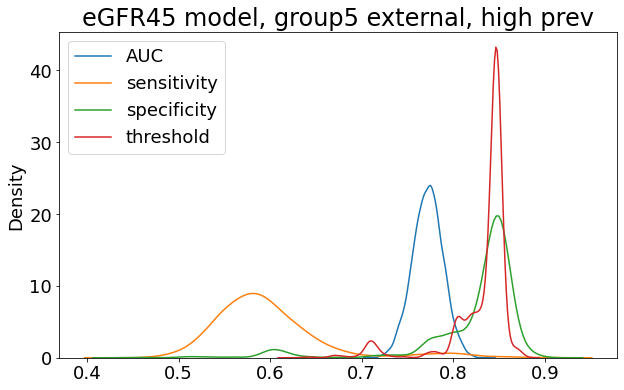

mean(ci): 0.77 (0.74-0.80), median:0.77
mean(ci): 0.60 (0.51-0.80), median:0.59
mean(ci): 0.82 (0.60-0.87), median:0.84
mean(ci): 0.83 (0.71-0.86), median:0.85


In [132]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s5_ev, label='AUC') 
sns.kdeplot(se_box_s5_ev, label='sensitivity')
sns.kdeplot(sp_box_s5_ev, label='specificity')
sns.kdeplot(th_box_s5_ev, label='threshold')
plt.title("eGFR45 model, group5 external, high prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(auc_box_s5_ev)
cical(se_box_s5_ev)
cical(sp_box_s5_ev)
cical(th_box_s5_ev)

In [133]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5_ev['prob']
y_test = X_test_g5_ev['eGFR_ab45']
weight = X_test_g5_ev['wt']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=weight)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR45 model, group5 external')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob, sample_weight=weight), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal'], sample_weight=weight))

eGFR45 model, group5 external
AUC         : 0.77
sensitivity : 0.57
specificity : 0.84
Threshold   : 0.85

Classification Report

              precision    recall  f1-score   support

      normal       0.98      0.84      0.91 2783899.567915305
    abnormal       0.11      0.57      0.18 94060.91921854872

    accuracy                           0.84 2877960.4871338536
   macro avg       0.55      0.71      0.55 2877960.4871338536
weighted avg       0.95      0.84      0.88 2877960.4871338536



## accuracy in eGFR<60, eGFR<45 and eGFR<30

### external

### all

In [88]:
X_test_bs_ev['pred'] = np.where(X_test_bs_ev['prob']>=0.48, 1, 0)
X_test_bs_ev['pred'].value_counts()

print('external validation')
#60
X_test_bs_60_ev = X_test_bs_ev.query('eGFR_ckd<60')
X_test_bs_60_ev['acc'] = X_test_bs_60_ev['eGFR_ab'] == X_test_bs_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_60_ev['wt']), sum(X_test_bs_60_ev.query('acc==1')['wt']), sum(X_test_bs_60_ev.query('acc==1')['wt'])/sum(X_test_bs_60_ev['wt'])*100))

#45
X_test_bs_45_ev = X_test_bs_ev.query('eGFR_ckd<45')
X_test_bs_45_ev['eGFR_ab45'] = np.where(X_test_bs_45_ev['eGFR_ckd']<45,1,0)
X_test_bs_45_ev['acc'] = X_test_bs_45_ev['eGFR_ab'] == X_test_bs_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_45_ev['wt']), sum(X_test_bs_45_ev.query('acc==1')['wt']), sum(X_test_bs_45_ev.query('acc==1')['wt'])/sum(X_test_bs_45_ev['wt'])*100))

#30
X_test_bs_30_ev = X_test_bs_ev.query('eGFR_ckd<30')
X_test_bs_30_ev['eGFR_ab30'] = np.where(X_test_bs_30_ev['eGFR_ckd']<30,1,0)
X_test_bs_30_ev['acc'] = X_test_bs_30_ev['eGFR_ab'] == X_test_bs_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_30_ev['wt']), sum(X_test_bs_30_ev.query('acc==1')['wt']), sum(X_test_bs_30_ev.query('acc==1')['wt'])/sum(X_test_bs_30_ev['wt'])*100))

external validation
60all: 726038 right: 547375 ratio: 75.4
45all: 170449 right: 148732 ratio: 87.3
30all: 55485 right: 47432 ratio: 85.5


In [89]:
# test set
data = X_test_bs_60_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_all_60_ev = []
se_all_45_ev = []
se_all_30_ev = []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_all_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_all_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_all_30_ev.append(se30)
        
        pbar.update()

10000it [02:10, 76.67it/s]                         


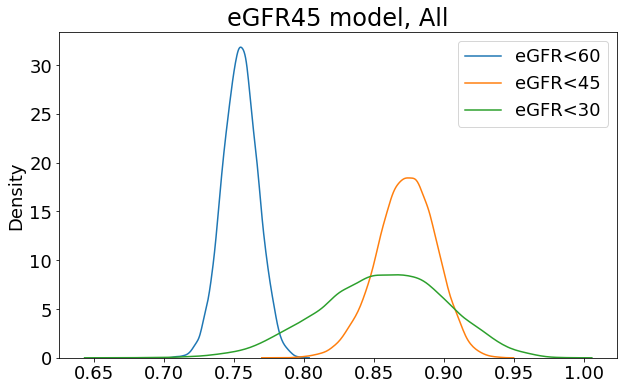

mean(ci): 0.75 (0.73-0.78), median:0.75
mean(ci): 0.87 (0.83-0.91), median:0.87
mean(ci): 0.86 (0.77-0.94), median:0.86


In [90]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_all_60_ev, label='eGFR<60') 
sns.kdeplot(se_all_45_ev, label='eGFR<45') 
sns.kdeplot(se_all_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, All", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_all_60_ev)
cical(se_all_45_ev)
cical(se_all_30_ev)

### group1, diabetes

In [91]:
X_test_g1_ev['pred'] = np.where(X_test_g1_ev['prob']>=0.68, 1, 0)
X_test_g1_ev['pred'].value_counts()

print('external validation')
#60
X_test_g1_60_ev = X_test_g1_ev.query('eGFR_ckd<60')
X_test_g1_60_ev['acc'] = X_test_g1_60_ev['eGFR_ab'] == X_test_g1_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_60_ev['wt']), sum(X_test_g1_60_ev.query('acc==1')['wt']), sum(X_test_g1_60_ev.query('acc==1')['wt'])/sum(X_test_g1_60_ev['wt'])*100))

#45
X_test_g1_45_ev = X_test_g1_ev.query('eGFR_ckd<45')
X_test_g1_45_ev['eGFR_ab45'] = np.where(X_test_g1_45_ev['eGFR_ckd']<45,1,0)
X_test_g1_45_ev['acc'] = X_test_g1_45_ev['eGFR_ab'] == X_test_g1_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_45_ev['wt']), sum(X_test_g1_45_ev.query('acc==1')['wt']), sum(X_test_g1_45_ev.query('acc==1')['wt'])/sum(X_test_g1_45_ev['wt'])*100))

#30
X_test_g1_30_ev = X_test_g1_ev.query('eGFR_ckd<30')
X_test_g1_30_ev['eGFR_ab30'] = np.where(X_test_g1_30_ev['eGFR_ckd']<30,1,0)
X_test_g1_30_ev['acc'] = X_test_g1_30_ev['eGFR_ab'] == X_test_g1_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g1_30_ev['wt']), sum(X_test_g1_30_ev.query('acc==1')['wt']), sum(X_test_g1_30_ev.query('acc==1')['wt'])/sum(X_test_g1_30_ev['wt'])*100))

external validation
60all: 255630 right: 149953 ratio: 58.7
45all: 73384 right: 50611 ratio: 69.0
30all: 25412 right: 19997 ratio: 78.7


In [92]:
# test set
data = X_test_g1_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g1_60_ev = []
se_g1_45_ev = []
se_g1_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g1_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g1_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g1_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:15<00:00, 73.53it/s]


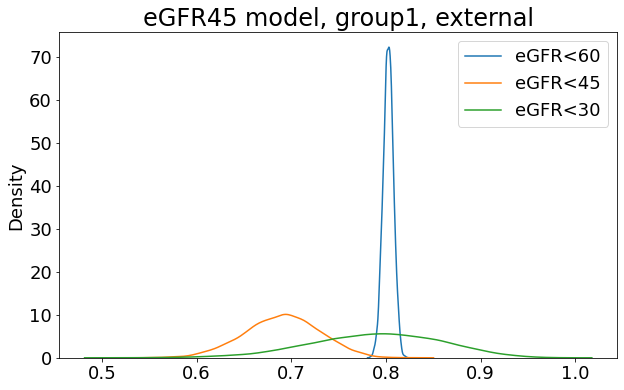

mean(ci): 0.80 (0.79-0.81), median:0.80
mean(ci): 0.69 (0.61-0.77), median:0.69
mean(ci): 0.79 (0.65-0.91), median:0.79


In [93]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g1_60_ev, label='eGFR<60') 
sns.kdeplot(se_g1_45_ev, label='eGFR<45') 
sns.kdeplot(se_g1_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, group1, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g1_60_ev)
cical(se_g1_45_ev)
cical(se_g1_30_ev)

### group2, hypertension

In [94]:
X_test_g2_ev['pred'] = np.where(X_test_g2_ev['prob']>=0.64, 1, 0)
X_test_g2_ev['pred'].value_counts()

print('external validation')
#60
X_test_g2_60_ev = X_test_g2_ev.query('eGFR_ckd<60')
X_test_g2_60_ev['acc'] = X_test_g2_60_ev['eGFR_ab'] == X_test_g2_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_60_ev['wt']), sum(X_test_g2_60_ev.query('acc==1')['wt']), sum(X_test_g2_60_ev.query('acc==1')['wt'])/sum(X_test_g2_60_ev['wt'])*100))

#45
X_test_g2_45_ev = X_test_g2_ev.query('eGFR_ckd<45')
X_test_g2_45_ev['eGFR_ab45'] = np.where(X_test_g2_45_ev['eGFR_ckd']<45,1,0)
X_test_g2_45_ev['acc'] = X_test_g2_45_ev['eGFR_ab'] == X_test_g2_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_45_ev['wt']), sum(X_test_g2_45_ev.query('acc==1')['wt']), sum(X_test_g2_45_ev.query('acc==1')['wt'])/sum(X_test_g2_45_ev['wt'])*100))

#30
X_test_g2_30_ev = X_test_g2_ev.query('eGFR_ckd<30')
X_test_g2_30_ev['eGFR_ab30'] = np.where(X_test_g2_30_ev['eGFR_ckd']<30,1,0)
X_test_g2_30_ev['acc'] = X_test_g2_30_ev['eGFR_ab'] == X_test_g2_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g2_30_ev['wt']), sum(X_test_g2_30_ev.query('acc==1')['wt']), sum(X_test_g2_30_ev.query('acc==1')['wt'])/sum(X_test_g2_30_ev['wt'])*100))

external validation
60all: 488990 right: 323079 ratio: 66.1
45all: 128924 right: 103497 ratio: 80.3
30all: 47562 right: 39204 ratio: 82.4


In [95]:
# test set
data = X_test_g2_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g2_60_ev = []
se_g2_45_ev = []
se_g2_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g2_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g2_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g2_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:49<00:00, 58.89it/s]


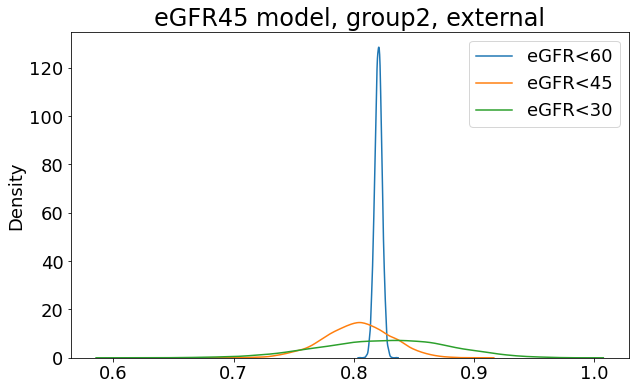

mean(ci): 0.82 (0.81-0.83), median:0.82
mean(ci): 0.80 (0.75-0.86), median:0.80
mean(ci): 0.83 (0.72-0.92), median:0.83


In [96]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g2_60_ev, label='eGFR<60') 
sns.kdeplot(se_g2_45_ev, label='eGFR<45') 
sns.kdeplot(se_g2_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, group2, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g2_60_ev)
cical(se_g2_45_ev)
cical(se_g2_30_ev)

### group3, old age >= 65

In [97]:
X_test_g3_ev['pred'] = np.where(X_test_g3_ev['prob']>=0.81, 1, 0)
X_test_g3_ev['pred'].value_counts()

print('external validation')
#60
X_test_g3_60_ev = X_test_g3_ev.query('eGFR_ckd<60')
X_test_g3_60_ev['acc'] = X_test_g3_60_ev['eGFR_ab'] == X_test_g3_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_60_ev['wt']), sum(X_test_g3_60_ev.query('acc==1')['wt']), sum(X_test_g3_60_ev.query('acc==1')['wt'])/sum(X_test_g3_60_ev['wt'])*100))

#45
X_test_g3_45_ev = X_test_g3_ev.query('eGFR_ckd<45')
X_test_g3_45_ev['eGFR_ab45'] = np.where(X_test_g3_45_ev['eGFR_ckd']<45,1,0)
X_test_g3_45_ev['acc'] = X_test_g3_45_ev['eGFR_ab'] == X_test_g3_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_45_ev['wt']), sum(X_test_g3_45_ev.query('acc==1')['wt']), sum(X_test_g3_45_ev.query('acc==1')['wt'])/sum(X_test_g3_45_ev['wt'])*100))

#30
X_test_g3_30_ev = X_test_g3_ev.query('eGFR_ckd<30')
X_test_g3_30_ev['eGFR_ab30'] = np.where(X_test_g3_30_ev['eGFR_ckd']<30,1,0)
X_test_g3_30_ev['acc'] = X_test_g3_30_ev['eGFR_ab'] == X_test_g3_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g3_30_ev['wt']), sum(X_test_g3_30_ev.query('acc==1')['wt']), sum(X_test_g3_30_ev.query('acc==1')['wt'])/sum(X_test_g3_30_ev['wt'])*100))

external validation
60all: 508471 right: 210797 ratio: 41.5
45all: 112748 right: 65865 ratio: 58.4
30all: 24062 right: 17363 ratio: 72.2


In [98]:
# test set
data = X_test_g3_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g3_60_ev = []
se_g3_45_ev = []
se_g3_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g3_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g3_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g3_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:36<00:00, 63.86it/s]


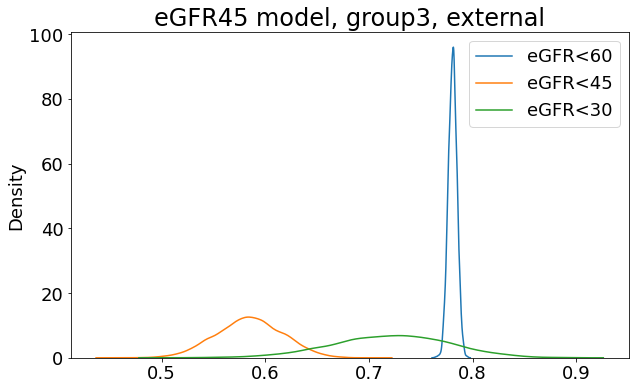

mean(ci): 0.78 (0.77-0.79), median:0.78
mean(ci): 0.58 (0.52-0.65), median:0.58
mean(ci): 0.72 (0.61-0.83), median:0.72


In [99]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g3_60_ev, label='eGFR<60') 
sns.kdeplot(se_g3_45_ev, label='eGFR<45') 
sns.kdeplot(se_g3_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, group3, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g3_60_ev)
cical(se_g3_45_ev)
cical(se_g3_30_ev)

### group4, proteinuria

In [100]:
X_test_g4_ev['pred'] = np.where(X_test_g4_ev['prob']>=0.82, 1, 0)
X_test_g4_ev['pred'].value_counts()

print('external validation')
#60
X_test_g4_60_ev = X_test_g4_ev.query('eGFR_ckd<60')
X_test_g4_60_ev['acc'] = X_test_g4_60_ev['eGFR_ab'] == X_test_g4_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_60_ev['wt']), sum(X_test_g4_60_ev.query('acc==1')['wt']), sum(X_test_g4_60_ev.query('acc==1')['wt'])/sum(X_test_g4_60_ev['wt'])*100))

#45
X_test_g4_45_ev = X_test_g4_ev.query('eGFR_ckd<45')
X_test_g4_45_ev['eGFR_ab45'] = np.where(X_test_g4_45_ev['eGFR_ckd']<45,1,0)
X_test_g4_45_ev['acc'] = X_test_g4_45_ev['eGFR_ab'] == X_test_g4_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_45_ev['wt']), sum(X_test_g4_45_ev.query('acc==1')['wt']), sum(X_test_g4_45_ev.query('acc==1')['wt'])/sum(X_test_g4_45_ev['wt'])*100))

#30
X_test_g4_30_ev = X_test_g4_ev.query('eGFR_ckd<30')
X_test_g4_30_ev['eGFR_ab30'] = np.where(X_test_g4_30_ev['eGFR_ckd']<30,1,0)
X_test_g4_30_ev['acc'] = X_test_g4_30_ev['eGFR_ab'] == X_test_g4_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g4_30_ev['wt']), sum(X_test_g4_30_ev.query('acc==1')['wt']), sum(X_test_g4_30_ev.query('acc==1')['wt'])/sum(X_test_g4_30_ev['wt'])*100))

external validation
60all: 100487 right: 89079 ratio: 88.6
45all: 54487 right: 50501 ratio: 92.7
30all: 31588 right: 29487 ratio: 93.3


In [101]:
# test set
data = X_test_g4_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g4_60_ev = []
se_g4_45_ev = []
se_g4_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g4_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g4_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g4_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:02<00:00, 81.92it/s]


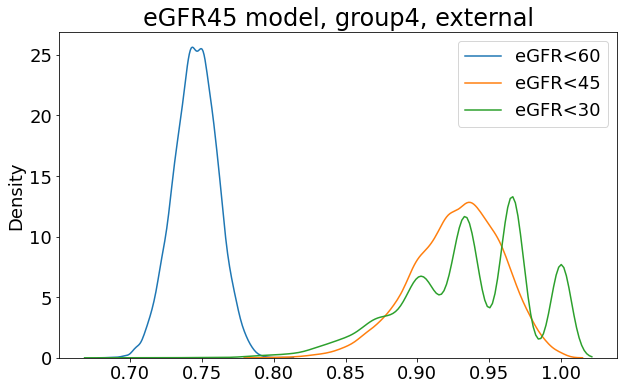

mean(ci): 0.75 (0.72-0.77), median:0.75
mean(ci): 0.93 (0.86-0.98), median:0.93
mean(ci): 0.93 (0.84-1.00), median:0.94


In [102]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g4_60_ev, label='eGFR<60') 
sns.kdeplot(se_g4_45_ev, label='eGFR<45') 
sns.kdeplot(se_g4_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, group4, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g4_60_ev)
cical(se_g4_45_ev)
cical(se_g4_30_ev)

### group5, high prevalence

In [103]:
X_test_g5_ev['pred'] = np.where(X_test_g5_ev['prob']>=0.81, 1, 0)
X_test_g5_ev['pred'].value_counts()

print('external validation')
#60
X_test_g5_60_ev = X_test_g5_ev.query('eGFR_ckd<60')
X_test_g5_60_ev['acc'] = X_test_g5_60_ev['eGFR_ab'] == X_test_g5_60_ev['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_60_ev['wt']), sum(X_test_g5_60_ev.query('acc==1')['wt']), sum(X_test_g5_60_ev.query('acc==1')['wt'])/sum(X_test_g5_60_ev['wt'])*100))

#45
X_test_g5_45_ev = X_test_g5_ev.query('eGFR_ckd<45')
X_test_g5_45_ev['eGFR_ab45'] = np.where(X_test_g5_45_ev['eGFR_ckd']<45,1,0)
X_test_g5_45_ev['acc'] = X_test_g5_45_ev['eGFR_ab'] == X_test_g5_45_ev['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_45_ev['wt']), sum(X_test_g5_45_ev.query('acc==1')['wt']), sum(X_test_g5_45_ev.query('acc==1')['wt'])/sum(X_test_g5_45_ev['wt'])*100))

#30
X_test_g5_30_ev = X_test_g5_ev.query('eGFR_ckd<30')
X_test_g5_30_ev['eGFR_ab30'] = np.where(X_test_g5_30_ev['eGFR_ckd']<30,1,0)
X_test_g5_30_ev['acc'] = X_test_g5_30_ev['eGFR_ab'] == X_test_g5_30_ev['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_g5_30_ev['wt']), sum(X_test_g5_30_ev.query('acc==1')['wt']), sum(X_test_g5_30_ev.query('acc==1')['wt'])/sum(X_test_g5_30_ev['wt'])*100))

external validation
60all: 394557 right: 171525 ratio: 43.5
45all: 94061 right: 57311 ratio: 60.9
30all: 21733 right: 16223 ratio: 74.6


In [104]:
# test set
data = X_test_g5_ev

# configure bootstrap
n_iterations = 10000
#n_size = len(data)

# run bootstrap
se_g5_60_ev = []
se_g5_45_ev = []
se_g5_30_ev = []

with tqdm.tqdm(total=n_iterations) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=len(data), replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        boot['acc'] = boot['eGFR_ab'] == boot['pred']
        se = sum(boot.query('acc==1')['wt'])/sum(boot['wt'])
        se_g5_60_ev.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        boot45['acc45'] = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(boot45.query('acc45==1')['wt'])/sum(boot45['wt'])
        se_g5_45_ev.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        boot30['acc30'] = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(boot30.query('acc30==1')['wt'])/sum(boot30['wt'])
        se_g5_30_ev.append(se30)
        
        pbar.update()

100%|██████████| 10000/10000 [02:23<00:00, 69.85it/s]


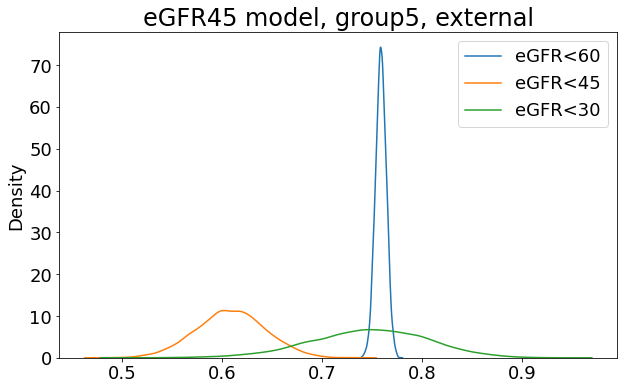

mean(ci): 0.76 (0.75-0.77), median:0.76
mean(ci): 0.61 (0.54-0.68), median:0.61
mean(ci): 0.75 (0.62-0.86), median:0.75


In [105]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g5_60_ev, label='eGFR<60') 
sns.kdeplot(se_g5_45_ev, label='eGFR<45') 
sns.kdeplot(se_g5_30_ev, label='eGFR<30') 
plt.title("eGFR45 model, group5, external", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g5_60_ev)
cical(se_g5_45_ev)
cical(se_g5_30_ev)

In [106]:
df_se_trend_ev = pd.DataFrame({
    'eGFR' : ['eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30'],
    
    'se'   : [0.88, 0.91, 0.89, 
              0.72, 0.83, 0.83, 
              0.72, 0.85, 0.82, 
              0.66, 0.71, 0.81, 
              0.75, 0.92, 0.93, 
              0.64, 0.73, 0.84],
    
    'lower' : [0.86, 0.87, 0.80,
               0.71, 0.77, 0.69,
               0.72, 0.79, 0.71,
               0.65, 0.65, 0.72,
               0.72, 0.85, 0.83,
               0.63, 0.67, 0.73],
    
    'upper' : [0.90, 0.95, 0.96,
               0.74, 0.90, 0.95,
               0.73, 0.90, 0.92,
               0.67, 0.76, 0.89,
               0.78, 0.98, 1.00,
               0.65, 0.79, 0.92],
    
    'group'  : ['All', 'All', 'All',
               'Diabetes', 'Diabetes', 'Diabetes',
               'Hypertension', 'Hypertension', 'Hypertension',
               'Old age', 'Old age', 'Old age',
               'Proteinuria','Proteinuria','Proteinuria',
               'High prev','High prev','High prev']
})
df_se_trend_ev['lower'] = df_se_trend_ev['se'] - df_se_trend_ev['lower']
df_se_trend_ev['upper'] = df_se_trend_ev['upper'] - df_se_trend_ev['se']
df_se_trend_ev

,eGFR,se,lower,upper,group
0,eGFR<60,0.88,0.02,0.02,All
1,eGFR<45,0.91,0.04,0.04,All
2,eGFR<30,0.89,0.09,0.07,All
3,eGFR<60,0.72,0.01,0.02,Diabetes
4,eGFR<45,0.83,0.06,0.07,Diabetes
5,eGFR<30,0.83,0.14,0.12,Diabetes
6,eGFR<60,0.72,0.00,0.01,Hypertension
7,eGFR<45,0.85,0.06,0.05,Hypertension
8,eGFR<30,0.82,0.11,0.10,Hypertension
9,eGFR<60,0.66,0.01,0.01,Old age


In [107]:
df_se_trend_sub_ev = df_se_trend_ev.query('group=="All"|group=="Old age"|group=="High prev"')
df_se_trend_sub_ev

,eGFR,se,lower,upper,group
0,eGFR<60,0.88,0.02,0.02,All
1,eGFR<45,0.91,0.04,0.04,All
2,eGFR<30,0.89,0.09,0.07,All
9,eGFR<60,0.66,0.01,0.01,Old age
10,eGFR<45,0.71,0.06,0.05,Old age
11,eGFR<30,0.81,0.09,0.08,Old age
15,eGFR<60,0.64,0.01,0.01,High prev
16,eGFR<45,0.73,0.06,0.06,High prev
17,eGFR<30,0.84,0.11,0.08,High prev


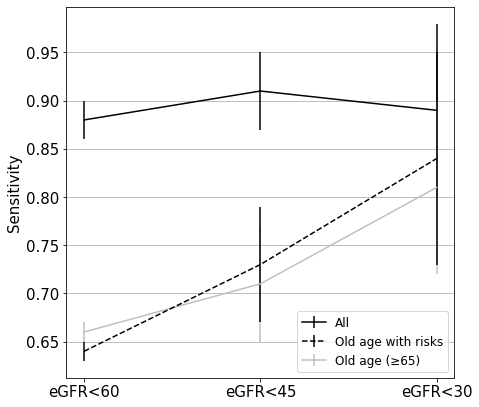

In [108]:
# trends of sensitivities plot
plt.rcParams["figure.figsize"] = (7,6)
fig,ax = plt.subplots()
#sns.set(style= "whitegrid")

df = df_se_trend_sub_ev
lvls = df.group.unique()
#for i in lvls:
#    ax.errorbar(x = df[df['group']==i]["eGFR"],
#                y=df[df['group']==i]["se"], 
#                yerr=[df[df['group']==i]["lower"], df[df['group']==i]["lower"]],
#               label=i)
    
ax.errorbar(x = df[df['group']=='All']["eGFR"],
            y=df[df['group']=='All']["se"], 
            yerr=[df[df['group']=='All']["lower"], df[df['group']=='All']["lower"]],
            label='All', color='k', linestyle='-')

ax.errorbar(x = df[df['group']=='Old age']["eGFR"],
            y=df[df['group']=='Old age']["se"], 
            yerr=[df[df['group']=='Old age']["lower"], df[df['group']=='Old age']["lower"]],
            label='Old age (≥65)', color='silver')

ax.errorbar(x = df[df['group']=='High prev']["eGFR"],
            y=df[df['group']=='High prev']["se"], 
            yerr=[df[df['group']=='High prev']["lower"], df[df['group']=='High prev']["lower"]],
            label='Old age with risks', color='k', linestyle='--')

#ax.axhline(y=0.5 , color='k', linestyle='--')
#ax.legend(loc=4, prop={'size':12})
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4, fontsize=12)

#plt.show()

plt.grid(axis='y')
plt.tight_layout()

#plt.savefig('/home/danssa/proj_ua/images/5sub/old_sen_external.png', dpi=300)